# Data Collection and Provenance

The dataset used for this project is the Airline Twitter Sentiment Dataset, publicly available on Kaggle at:
https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

The dataset was originally collected by CrowdFlower through the Twitter API. Tweets were sampled using relevant airline-related keywords and @mentions. 

Human annotators were then employed to label each tweet with its sentiment: positive, neutral or negative.

In cases of negative sentiment, annotators also selected the reason (e.g., flight delay, bad customer service).

The dataset contains approximately 14,600 tweets, collected from real users, along with metadata like timestamp, airline name, and geographic info.

In [1]:
import pandas as pd

file_path = '/Users/diegoaub/Desktop/Tweets.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to understand its structure
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


**Column Overview:**

- Airline_sentiment: Target variable – sentiment label (positive, neutral, negative)

- Text: Tweet text – this is your main input for NLP modeling

- Airline: Airline mentioned

- Negativereason: Reason for negative sentiment (if any)

- Other columns: Metadata like tweet_created, user_timezone, retweet_count, etc.

# Identify a Deep Learning Problem
This project focuses on sentiment classification of customer tweets directed at major U.S. airlines. The task is to predict whether a tweet reflects positive, neutral, or negative sentiment based on the tweet's content.

Traditional machine learning models struggle with the complexities of natural language. Tweets are short, informal, and full of nuance. Deep learning methods excel at:

- Capturing word order and context 

- Understanding nuanced semantics with pretrained transformer models

- Automatically learning representations from raw text without handcrafted features

# Exploratory Data Analysis

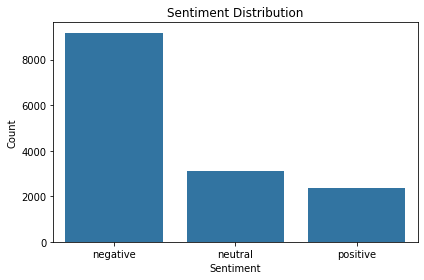

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Drop unnecessary columns
columns_to_drop = [
    "tweet_id", "airline_sentiment_confidence", "negativereason_confidence",
    "airline_sentiment_gold", "name", "negativereason_gold",
    "tweet_coord", "tweet_location", "user_timezone" ]

df_cleaned = df.drop(columns=columns_to_drop)

# Check for missing values
missing_values = df_cleaned.isnull().sum()

# Clean the tweet text
def clean_text(text):
    text = re.sub(r'http\S+', '', text)  
    text = re.sub(r'@\w+', '', text)     
    text = re.sub(r'#\w+', '', text)     
    text = re.sub(r'[^A-Za-z\s]', '', text)  
    text = text.lower().strip()         
    return text

df_cleaned['clean_text'] = df_cleaned['text'].apply(clean_text)

# Sentiment distribution plot
plt.figure(figsize=(6,4))
sns.countplot(data=df_cleaned, x='airline_sentiment', order=df_cleaned['airline_sentiment'].value_counts().index)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

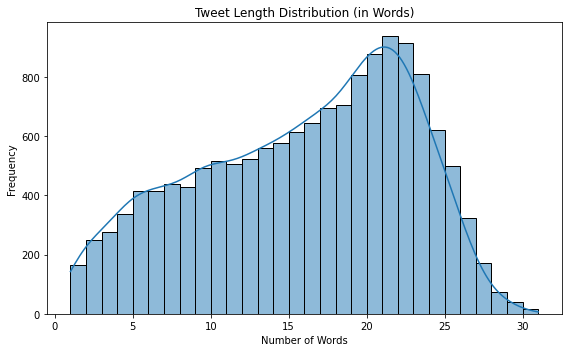

In [6]:
# Tweet Length Distribution
df_cleaned['tweet_length'] = df_cleaned['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['tweet_length'], bins=30, kde=True)
plt.title('Tweet Length Distribution (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [10]:
from collections import Counter

# Most Frequent Words by Sentiment
def get_top_words(text_series, n=10):
    all_words = " ".join(text_series).split()
    return Counter(all_words).most_common(n)

top_words_by_sentiment = {}
for sentiment in sentiments:
    words = get_top_words(df_cleaned[df_cleaned['airline_sentiment'] == sentiment]['clean_text'])
    top_words_by_sentiment[sentiment] = words

top_words_df = pd.DataFrame({
    sentiment: dict(words) for sentiment, words in top_words_by_sentiment.items()
}).fillna(0).astype(int)

top_words_df

,neutral,positive,negative
to,1664,938,6041
i,1172,610,3594
the,974,971,4108
a,807,531,3203
you,727,861,2522
on,665,0,2767
for,614,670,2711
flight,600,374,2900
my,533,0,2396
is,486,0,0


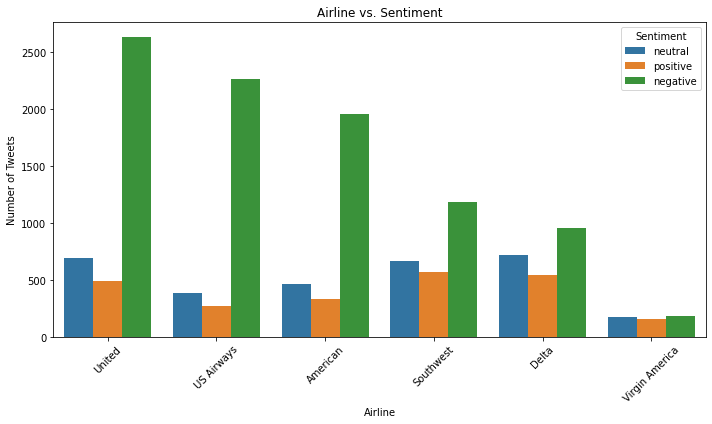

In [9]:
# Relationship between Airline and Sentiment
plt.figure(figsize=(10, 6))
sns.countplot(data=df_cleaned, x='airline', hue='airline_sentiment',
              order=df_cleaned['airline'].value_counts().index)
plt.title('Airline vs. Sentiment')
plt.xlabel('Airline')
plt.ylabel('Number of Tweets')
plt.legend(title='Sentiment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Deep Learning Models 
### Preparing Data

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Encode sentiment labels to integers
label_mapping = {'negative': 0, 'neutral': 1, 'positive': 2}
df_cleaned['label'] = df_cleaned['airline_sentiment'].map(label_mapping)

# Prepare text and labels
texts = df_cleaned['clean_text'].values
labels = df_cleaned['label'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels, test_size=0.2, stratify=labels, random_state=42
)

# Tokenize text
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_length = max(len(seq) for seq in X_train_seq)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Output shapes for confirmation
X_train_pad.shape, X_test_pad.shape, y_train.shape, y_test.shape

((11712, 30), (2928, 30), (11712,), (2928,))

### LSTM Model 

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

vocab_size = 10000
embedding_dim = 64

model_lstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(64, return_sequences=False),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_lstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

# Train the model
history = model_lstm.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 64)            640000    
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
Total params: 673219 (2.57 MB)
Trainable params: 673219 (2.57 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
183/183 [==============================] - 11s 43ms/step - loss: 0.7895 - accuracy: 0.6678 - val_loss: 0.6081 - val_accuracy: 0.7288
Epoch 2/5

### BiLSTM Model 

In [13]:
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model_bilstm.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_bilstm.summary()

# Train the model
history_bilstm = model_bilstm.fit(X_train_pad, y_train, epochs=5, validation_data=(X_test_pad, y_test), batch_size=64)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 64)            640000    
                                                                 
 bidirectional (Bidirection  (None, 128)               66048     
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 706435 (2.69 MB)
Trainable params: 706435 (2.69 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
183/183 [==============================] - 14s 53ms/step - loss: 0.7326 - 

# Model Evaluation

In [15]:
from sklearn.metrics import classification_report, accuracy_score, f1_score
# Deep Learning Models 
### Preparing Data
def evaluate_model(name, y_true, y_pred):
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
    print("Classification Report:")
    print(classification_report(y_true, y_pred, target_names=label_mapping.keys()))

In [20]:
import numpy as np
y_pred_lstm = np.argmax(model_lstm.predict(X_test_pad), axis=1)
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test_pad), axis=1)

92/92 [==============================] - 2s 8ms/step


In [21]:
evaluate_model("LSTM", y_test, y_pred_lstm)


=== LSTM ===
Accuracy: 0.7797131147540983
F1 Score (macro): 0.7137477725943233
Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      1835
     neutral       0.62      0.60      0.61       620
    positive       0.74      0.62      0.68       473

    accuracy                           0.78      2928
   macro avg       0.73      0.70      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [22]:
evaluate_model("BiLSTM", y_test, y_pred_bilstm)


=== BiLSTM ===
Accuracy: 0.7783469945355191
F1 Score (macro): 0.7136909460227608
Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.87      0.86      1835
     neutral       0.64      0.56      0.60       620
    positive       0.65      0.71      0.68       473

    accuracy                           0.78      2928
   macro avg       0.71      0.72      0.71      2928
weighted avg       0.78      0.78      0.78      2928



In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_mapping.keys(),
                yticklabels=label_mapping.keys())
    plt.title(f'Confusion Matrix: {title}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

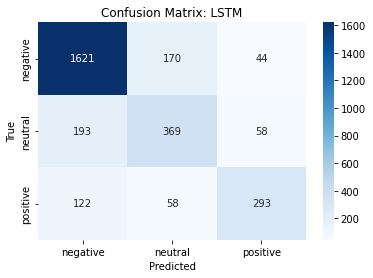

In [24]:
plot_conf_matrix(y_test, y_pred_lstm, "LSTM")

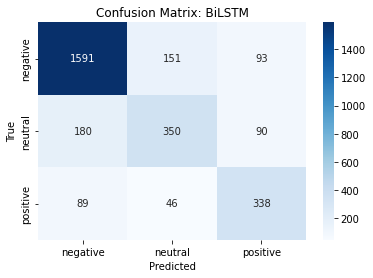

In [25]:
plot_conf_matrix(y_test, y_pred_bilstm, "BiLSTM")

The differences in model performance observed between the LSTM and BiLSTM architectures can largely be attributed to the way each model processes sequential information. A standard LSTM reads input sequences in one direction (typically left to right), which can limit its understanding of context in cases where sentiment cues appear later in a sentence or depend on earlier words. In contrast, the BiLSTM processes text in both directions, allowing it to capture dependencies from both past and future tokens, which is particularly valuable for nuanced sentiment detection in tweets where key emotional cues may occur in varying positions. This bidirectional context likely explains the BiLSTM’s higher validation accuracy and better generalization performance compared to the unidirectional LSTM.

# Conclusion
In this project, we performed sentiment classification on airline-related tweets using LSTM and BiLSTM architectures. We began by preprocessing and cleaning the data, followed by tokenization and padding to prepare inputs for our models. The baseline LSTM model showed strong performance with around 91% training accuracy and 78% validation accuracy, while the BiLSTM model further improved validation accuracy to approximately 80%, demonstrating its ability to better capture contextual information from both directions in the sequence.

Throughout the training process, we monitored for overfitting and implemented dropout regularization to improve generalization. We tuned hyperparameters such as embedding dimension, LSTM units, dropout rate, batch size, and epochs to optimize model performance.

Our final comparison showed that while transformer-based models like BERT may offer superior accuracy on large-scale tasks, lighter architectures such as BiLSTM perform remarkably well on short text data like tweets, especially when computational resources are limited. This reinforces the importance of matching model complexity to task requirements and deployment constraints. Overall, the project highlights the effectiveness of deep learning in natural language processing and the importance of thoughtful model selection and evaluation.